# Notebook for Coursera Program
Daniel Vareda


**Hypothesis**:


Number of Area in square feet can influence the price

## Libraries

In [1]:
# !pip install arviz
# !pip install pymc3

In [2]:
from scipy import stats
import arviz as az
import numpy as np
import matplotlib.pyplot as plt
import pymc3 as pm
import seaborn as sns
import pandas as pd
from theano import shared
from sklearn import preprocessing
from scipy.stats import gamma

print('Running on PyMC3 v{}'.format(pm.__version__))

Running on PyMC3 v3.11.5


In [3]:
pd.set_option('display.float_format', '{:.2f}'.format)

## Reading and Preparing Data

Reference Dataset:
[London House Price](https://www.kaggle.com/datasets/arnavkulkarni/housing-prices-in-london) 

In [4]:
import pandas as pd

data = pd.read_csv('London.csv')
data.drop(data.columns[0], axis=1, inplace=True)

In [5]:
data.tail()

,Property Name,Price,House Type,Area in sq ft,No. of Bedrooms,No. of Bathrooms,No. of Receptions,Location,City/County,Postal Code
3475,One Lillie Square,3350000,New development,1410,3,3,3,NaN,Lillie Square,SW6 1UE
3476,St. James's Street,5275000,Flat / Apartment,1749,3,3,3,St James's,London,SW1A 1JT
3477,Ingram Avenue,5995000,House,4435,6,6,6,Hampstead Garden Suburb,London,NW11 6TG
3478,Cork Street,6300000,New development,1506,3,3,3,Mayfair,London,W1S 3AR
3479,Courtenay Avenue,8650000,House,5395,6,6,6,Highgate,London,N6 4LP


In [6]:
df = data[['Area in sq ft','Price']]

In [7]:
df.rename(columns={'Area in sq ft': 'area_ft'}, inplace=True)
df.rename(columns={'Price': 'price'}, inplace=True)

/tmp/ipykernel_17698/2445773331.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.rename(columns={'Area in sq ft': 'area_ft'}, inplace=True)
/tmp/ipykernel_17698/2445773331.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.rename(columns={'Price': 'price'}, inplace=True)


In [8]:
df.head()

,area_ft,price
0,2716,1675000
1,814,650000
2,761,735000
3,1986,1765000
4,700,675000


In [9]:
df.columns

Index(['area_ft', 'price'], dtype='object')

## Checking the Data

In [10]:
df.describe()

,area_ft,price
count,3480.00,3480.00
mean,1712.97,1864172.54
std,1364.26,2267282.96
min,274.00,180000.00
25%,834.00,750000.00
50%,1310.00,1220000.00
75%,2157.25,2150000.00
max,15405.00,39750000.00


In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3480 entries, 0 to 3479
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype
---  ------   --------------  -----
 0   area_ft  3480 non-null   int64
 1   price    3480 non-null   int64
dtypes: int64(2)
memory usage: 54.5 KB


## Understanding the Overall Distribution

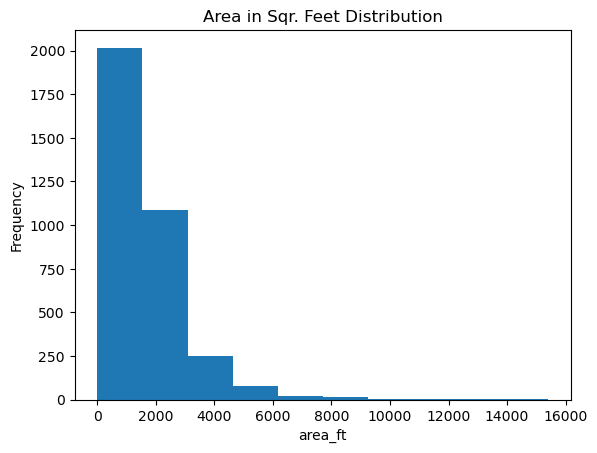

In [12]:
# Plot the distribution of recency values
plt.hist(df.area_ft, range=(0, 15405))
plt.title("Area in Sqr. Feet Distribution")
plt.xlabel("area_ft")
plt.ylabel("Frequency")
plt.show()

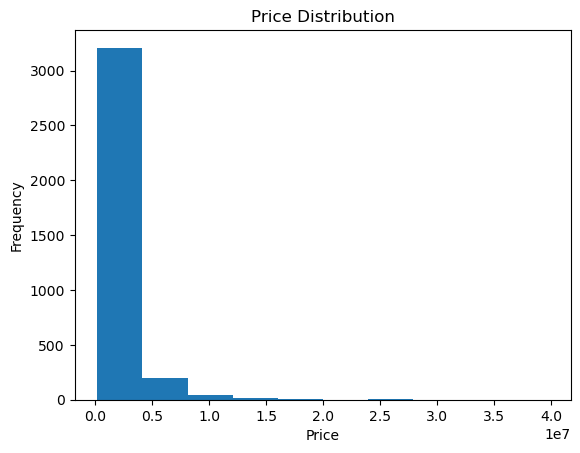

In [13]:
# Plot the distribution of recency values
plt.hist(df.price)
plt.title("Price Distribution")
plt.xlabel("Price")
plt.ylabel("Frequency")
plt.show()

In this case we wanna use then a Gamma Distribution

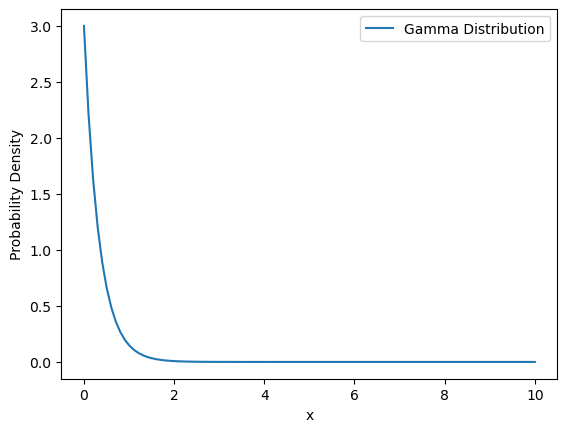

In [14]:
# Parameters for the gamma distribution
alpha = 1
beta = 3

# Generate x-values for the plot
x = np.linspace(0, 10, 100)

# Calculate the probability density function (PDF) for the gamma distribution
pdf = gamma.pdf(x, alpha, scale=1/beta)

# Plot the gamma distribution
plt.plot(x, pdf, label='Gamma Distribution')

# Add labels and a legend to the plot
plt.xlabel('x')
plt.ylabel('Probability Density')
plt.legend()

# Display the plot
plt.show()

## Understanding the Correlation

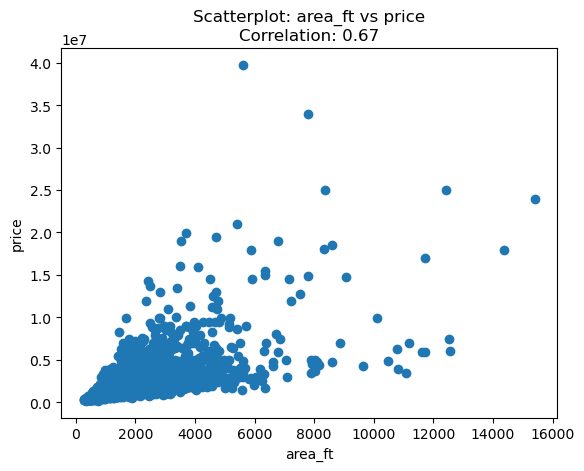

Correlation coefficient: 0.6677096038368738


In [15]:
# Select the two columns for the scatterplot
x_column = 'area_ft'
y_column = 'price'

# Create the scatterplot
plt.scatter(df[x_column], df[y_column])

# Calculate the correlation between the two columns
correlation = df[x_column].corr(df[y_column])

# Add labels and a title to the plot
plt.xlabel(x_column)
plt.ylabel(y_column)
plt.title('Scatterplot: {} vs {}\nCorrelation: {:.2f}'.format(x_column, y_column, correlation))

# Display the plot
plt.show()

# Print the correlation coefficient
print('Correlation coefficient:', correlation)

In [16]:
from sklearn.linear_model import LinearRegression


# Extract the features (x) and target variable (y)
X = df[[x_column]]
y = df[y_column]

# Create a linear regression model
model = LinearRegression()

# Fit the model to the data
model.fit(X, y)

# Retrieve the coefficients and intercept of the linear regression equation
coef = model.coef_[0]
intercept = model.intercept_

# Print the equation in the form y = mx + b
print('Equation: y = {:.2f}x + {:.2f}'.format(coef, intercept))

Equation: y = 1109.68x + -36674.05


In [17]:
# create the model using pm.Model()
with pm.Model() as model:
    
    #assign priors to the parameters
    alpha = pm.Normal('alpha', mu=0, sd=20)
    # alpha = pm.Uniform('alpha', lower=0, upper=10)
    beta_1 = pm.Gamma('beta_1', alpha=1, beta=1)
    
    #expected value
    mu = alpha + beta_1 * df.area_ft 
    
    #likelihood
    y_est = pm.Normal('y_est', mu=mu, sd=0.1, observed=df.price)
    
 #predict

 #use pm.sample to predict the buckets
    
with model:
    trace = pm.sample(2000, tune=1000, cores=2, step=pm.Metropolis())
    # trace = pm.sample(2000, tune=2000, cores=1, step=pm.NUTS(target_accept=0.95))

#extract the predicted values from the trace
buckets_pred = pm.sample_posterior_predictive(trace, model=model, samples=2000, progressbar=False)

#predict the bucket for each user
df['bucket_pred']=np.median(buckets_pred['y_est'], axis=0)





/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/deprecat/classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [beta_1]
>Metropolis: [alpha]


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/pymc3/step_methods/metropolis.py:226: RuntimeWarning: overflow encountered in exp
  "accept": np.exp(accept),
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/pymc3/step_methods/metropolis.py:226: RuntimeWarning: overflow encountered in exp
  "accept": np.exp(accept),
Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 7 seconds.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/pymc3/sampling.py:1708: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  warnings.warn(
/tmp/ipykernel_17698/1460682837.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy 

In [18]:
df['sub'] = df['bucket_pred'].sub(df['price'])
# average_difference

/tmp/ipykernel_17698/3624544463.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['sub'] = df['bucket_pred'].sub(df['price'])


In [19]:
df.head()

,area_ft,price,bucket_pred,sub
0,2716,1675000,2978253.13,1303253.13
1,814,650000,891686.50,241686.50
2,761,735000,833543.84,98543.84
3,1986,1765000,2177414.67,412414.67
4,700,675000,766625.13,91625.13


In [20]:
df['sub'].median()

190211.1360187331

In [21]:
from pymc3 import traceplot

/tmp/ipykernel_17698/1778458073.py:1: DeprecationWarning: The function `traceplot` from PyMC3 is just an alias for `plot_trace` from ArviZ. Please switch to `pymc3.plot_trace` or `arviz.plot_trace`.
  traceplot(trace)
Got error No model on context stack. trying to find log_likelihood in translation.
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/arviz/data/io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
Got error No model on context stack. trying to find log_likelihood in translation.


array([[<AxesSubplot: title={'center': 'alpha'}>,
        <AxesSubplot: title={'center': 'alpha'}>],
       [<AxesSubplot: title={'center': 'beta_1'}>,
        <AxesSubplot: title={'center': 'beta_1'}>]], dtype=object)

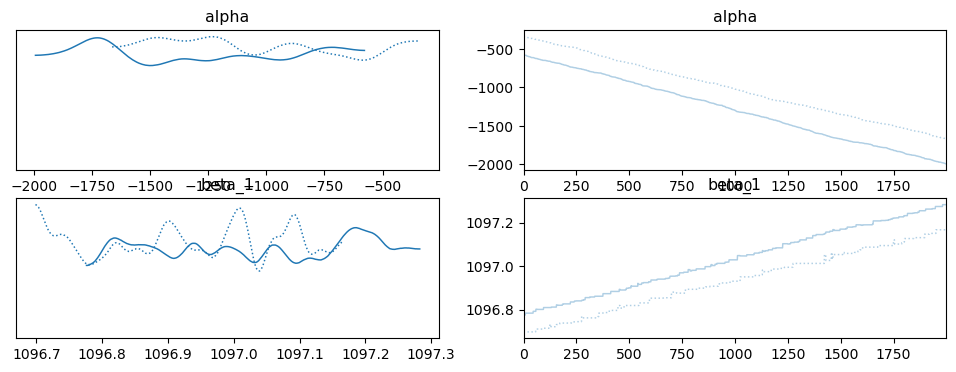

In [22]:
traceplot(trace)

In [23]:
from pymc3 import summary

In [24]:
summary(trace['alpha'])

arviz - WARNING - Shape validation failed: input_shape: (1, 4000), minimum_shape: (chains=2, draws=4)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
x,-1150.52,423.08,-1838.67,-359.59,199.39,151.30,4.00,11.00,NaN


In [26]:
summary(trace['beta_1'])

arviz - WARNING - Shape validation failed: input_shape: (1, 4000), minimum_shape: (chains=2, draws=4)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
x,1096.98,0.15,1096.70,1097.22,0.07,0.05,4.00,9.00,NaN
